In [21]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [22]:
import xarray as xr

filename = "OBS6_ERA5_reanaly_1_day_pr_2010-2012.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
ds = xr.open_dataset(filename)
# Convert to a pandas DataFrame
df = ds.to_dataframe()
# Reset the index if needed
df.reset_index(inplace=True)
df = df[df['bnds'] == 0]
df.index = pd.to_datetime(df['time'])
df.drop(columns=['time', 'bnds'], inplace=True)
prec  = df['pr']  # Precipitation data
prec  = prec*86400  # Convert from m/s to mm/day)
prec[prec < 0] = 0  # Set negative values to zero
prec


time
2010-01-01 12:00:00     1.570316
2010-01-02 12:00:00     0.038551
2010-01-03 12:00:00     2.237453
2010-01-04 12:00:00    11.731629
2010-01-05 12:00:00     6.421555
                         ...    
2012-12-27 12:00:00     0.000000
2012-12-28 12:00:00     0.000000
2012-12-29 12:00:00     0.032534
2012-12-30 12:00:00     0.002093
2012-12-31 12:00:00     0.009044
Name: pr, Length: 1096, dtype: float64

In [23]:
filename = "Derived_Makkink_evspsblpot.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
dsEP = xr.open_dataset(filename)
# Convert to a pandas DataFrame
dfEP = dsEP.to_dataframe()
# Reset the index if needed
dfEP.reset_index(inplace=True)
EP = dfEP['evspsblpot']  # Evapotranspiration data
EP.index = pd.to_datetime(dfEP['time'])
EP = EP*86400  # Convert from mm/s to mm/day)
EP[EP < 0] = 0  # Set negative values to zero
EP.loc[EP.index.month == 8]

time
2010-08-01 12:00:00    5.154735
2010-08-02 12:00:00    5.408309
2010-08-03 12:00:00    4.440235
2010-08-04 12:00:00    5.019661
2010-08-05 12:00:00    5.293723
                         ...   
2012-08-27 12:00:00    4.743519
2012-08-28 12:00:00    4.946479
2012-08-29 12:00:00    4.770978
2012-08-30 12:00:00    3.781321
2012-08-31 12:00:00    4.490458
Name: evspsblpot, Length: 93, dtype: float64

In [ ]:
filename = "6227510_Q_Day.Cmd.txt"
A = 21497*10**6 #m^2
dfQ = pd.read_csv(filename, delimiter=";", skiprows=37, header=None, encoding='latin1')  # Specify encoding
dfQ = dfQ[[0, 2]]  # Select only the first and third columns
dfQ.columns = ['Date', 'Q']  # Rename columns for clarity
dfQ['Date'] = pd.to_datetime(dfQ['Date'], format='%Y-%m-%d')  # Convert 'Date' column to datetime
dfQ.set_index('Date', inplace=True)  # Set 'Date' as the index
dfQ['Q'] = (dfQ['Q']/A)*(10**3)*86400 #mm/day
dfQ

,Q
Date,
1946-10-01,0.126604
1946-10-02,0.123790
1946-10-03,0.118163
1946-10-04,0.115350
1946-10-05,0.111331
...,...
2017-09-26,0.042282
2017-09-27,0.043327
2017-09-28,0.044331


In [25]:
EP_mean = EP.mean()
#EP2_mean = Water_balance['EP_2'].mean()
#EP3_mean = Water_balance['EP_3'].mean()

P_mean = prec.mean()
#P2_mean = Water_balance['P_2'].mean()
#P3_mean = Water_balance['P_3'].mean()

Q_mean = dfQ['Q'].mean()
#Q2_mean = Water_balance['Q_2'].mean()
#Q3_mean = Water_balance['Q_3'].mean()

EP1_P1 = EP_mean/P_mean
#EP2_P2 = EP2_mean/P2_mean
#EP3_P3 = EP3_mean/P3_mean

EA1_P1 = 1- Q_mean/P_mean
#EA2_P2 = 1- Q2_mean/P2_mean
#EA3_P3 = 1- Q3_mean/P3_mean

In [26]:
EA1_P1_Bud = (EP_mean/P_mean*np.tanh(1/(EP_mean/P_mean))*(1-np.exp(-EP_mean/P_mean)))**(0.5)
#EA2_P2_Bud = (EP2_mean/P2_mean*np.tanh(1/(EP2_mean/P2_mean))*(1-np.exp(-EP2_mean/P2_mean)))**(0.5)
#EA3_P3_Bud = (EP3_mean/P3_mean*np.tanh(1/(EP3_mean/P3_mean))*(1-np.exp(-EP3_mean/P3_mean)))**(0.5)

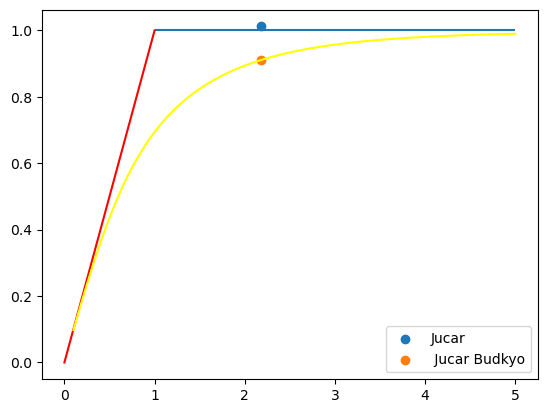

In [27]:
x = np.linspace(0,1,100)

EP_P = np.linspace(0.1,5,100)
EA_P_Bud = (EP_P*np.tanh(1/(EP_P))*(1-np.exp(-EP_P)))**(0.5)

plt.scatter(EP1_P1, EA1_P1, label = 'Jucar')
#plt.scatter(EP2_P2 , EA2_P2, label = 'C2')
#plt.scatter(EP3_P3 , EA3_P3, label = 'C3')
plt.scatter(EP1_P1, EA1_P1_Bud, label = ' Jucar Budkyo')
#plt.scatter(EP2_P2 , EA2_P2_Bud, label = 'C2 Budkyo')
#plt.scatter(EP3_P3 , EA3_P3_Bud, label = 'C3 Budkyo')
plt.hlines(y = 1, xmin= 1, xmax= 5)
plt.plot(x,x, color ='red')
plt.plot(EP_P, EA_P_Bud, color= 'yellow')
plt.legend()
plt.show()

In [28]:
EA1 = EA1_P1_Bud*P_mean
#EA2 = EA2_P2_Bud*P2_mean
#EA3 = EA3_P3_Bud*P3_mean

Water_balance_C1 = P_mean - EA1 - Q_mean
#Water_balance_C2 = P2_mean - EA2 - Q2_mean
#Water_balance_C3 = P3_mean- EA3 - Q3_mean

print(Water_balance_C1)
#print(Water_balance_C2)
#print(Water_balance_C3)

0.1391045271627067
